In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import torch
import torch.utils.data as data
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import zipfile
import shutil
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
from os.path import exists

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [ ]:
zipfile_path = '/content/drive/MyDrive/plantdiseasesdataset.zip'
with zipfile.ZipFile(zipfile_path,'r') as f:
  f.extractall('.')

FileNotFoundError: ignored

In [ ]:
np.random.seed(41) # setting the random seed to be able to reproduce results


train_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/content/test'

# Verify that each directory contains the correct classes
train_classes = os.listdir(train_dir)
validation_classes = os.listdir(validation_dir)
print('Classes in train directory: ', train_classes)
print('Classes in validation directory: ', validation_classes)


def three_data_augmentations_function(image): # ADD GREY BLOCK, APPLY RANDOM OR CENTER CROP, OR NONE
    rand_num1 = round(random.random(), 3)
    if (rand_num1 < 0.05): # ADD GREY BLOCK
        block_size = 50    # Adjust the block size as desired
        height, width = image.size[1], image.size[0]
        x = torch.randint(0, width - block_size, (1,))
        y = torch.randint(0, height - block_size, (1,))

        # Apply paste operation on the input image
        image.paste((128, 128, 128), (x.item(), y.item(), x.item() + block_size, y.item() + block_size))
        return image

    elif (0.05 <= rand_num1 < 0.1):  # APPLY RANDOM CROP
        return transforms.RandomCrop(size=180)(image)

    elif (0.1 <= rand_num1 < 0.15):  # APPLY CENTER CROP
        return transforms.CenterCrop(size=180)(image)
    return image

# Define the transformation to add Gaussian noise
def add_gaussian_noise(image):
    mean = 0.0
    std = 0.9  # Adjust the standard deviation as desired
    rand_num2 = round(random.random(), 3)
    if rand_num2 < 0.05:
      noise = torch.randn_like(image) * std + mean
      noisy_image = torch.clamp(image + noise, min=0.0, max=1.0)
      return noisy_image
    return image

# Define the transformations to be applied to the images
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(three_data_augmentations_function),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Lambda(add_gaussian_noise),

        # Add other transformations if desired
        # transforms.RandomResizedCrop(224),
        # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Load the 3 datasets using ImageFolder and apply transformations
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
validation_data = datasets.ImageFolder(validation_dir, transform = data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

Classes in train directory:  ['Squash___Powdery_mildew', 'Corn_(maize)___healthy', 'Potato___Late_blight', 'Tomato___healthy', 'Pepper,_bell___healthy', 'Tomato___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Cherry_(including_sour)___healthy', 'Strawberry___Leaf_scorch', 'Blueberry___healthy', 'Strawberry___healthy', 'Corn_(maize)___Common_rust_', 'Tomato___Tomato_mosaic_virus', 'Tomato___Early_blight', 'Peach___healthy', 'Grape___Esca_(Black_Measles)', 'Potato___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Leaf_Mold', 'Grape___Black_rot', 'Potato___Early_blight', 'Tomato___Late_blight', 'Grape___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Target_Spot', 'Tomato___Septoria_leaf_spot', 'Soybean___healthy', 'Apple___healthy', 'Apple___Apple_scab', 'Apple___Cedar_apple_rust', 'Apple___Black_rot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Peach___Bacterial_spot', 'Raspberry___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf

In [ ]:
# define dataloader parameters
batch_size  = 128
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

# Print the number of images in each set
print( 'Number of training images: ', len(train_data))
print( 'Number of validation images: ', len(validation_data))
print( 'Number of test images: ', len(test_data))


Number of training images:  70295
Number of validation images:  17572
Number of test images:  33


In [ ]:
# Initial simple model
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        self.conv1 = nn.Conv2d(3, 16, kernel_size=6, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=2)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, 38)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))

        x = self.flatten(x)
        x = self.fc(x)

        return x

In [ ]:
# Skip connections
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 16, kernel_size=6, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.3)
        self.flatten = nn.Flatten()
        self.norm1 = nn.LayerNorm(3000)
        self.norm2 = nn.LayerNorm(500)
        self.fc1 = nn.Linear(2048, 3000)
        self.fc2 = nn.Linear(3000, 500)
        self.fc3 = nn.Linear(500, 38)

    def forward(self, x):
        self.skip_connections = []  # Reset the skip connections

        # Convolutional layers with skip connections
        x = self.conv1(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv2(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv3(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv4(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv5(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv6(x)
        self.skip_connections.append(x)
        x = self.relu(x)

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.norm1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    loss = float(total_loss) / (i + 1)
    return loss


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
#from tutorial 3a
def get_accuracy(model, dataset_acc):
    correct = 0
    total = 0
    for imgs, labels in dataset_acc:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)


        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
use_cuda = True

def train_net(net, training_set, validation_set, batch_size=64, learning_rate=0.01, num_epochs=30, weight_decay = 0.001):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
    ########################################################################
    # Define the Loss function and optimizer
    # the neural network and scalar label.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr= learning_rate, weight_decay = weight_decay)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    training_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    training_acc = np.zeros(num_epochs)
    validation_acc = np.zeros(num_epochs)
    best_accuracy = 0.0
    best_param = None
    model_path = None
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        n = 0
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            # Calculate the statistics
            n += 1
            total_train_loss += loss.item()
            total_epoch += len(labels)
        del imgs, labels
        torch.cuda.empty_cache()
        # track accuracy
        training_acc[epoch] = get_accuracy(net, train_loader)
        training_loss[epoch] = float(total_train_loss) / (n+1)
        validation_acc[epoch] = get_accuracy(net, val_loader)
        val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Training acc: {} |" + " Validation acc: {}").format(epoch, training_acc[epoch], validation_acc[epoch]))
        if validation_acc[epoch] > best_accuracy:
          best_accuracy = validation_acc[epoch]
          best_params = net.state_dict()  # Save the current model's parameters
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch)


    torch.save(best_params, model_path)
    print("best acc: ", best_accuracy)
    epochs = np.arange(1, num_epochs + 1)
    return epochs, training_acc, training_loss, validation_acc,  val_loss

In [ ]:
import matplotlib.pyplot as plt
def plotting (epochs, train_acc, train_loss, val_acc, val_loss):
  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  plt.title("Losses Curve")
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, val_loss, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
# One way to sanity check our neural network model and training code is to
# check whether the model is capable of “overfitting” or “memorizing” a small
# dataset. A properly constructed CNN with correct training code should be able
# to memorize the answers to a small number of images quickly.

# We need to take a small ammount of the data (as 70000 is too big)
# to test out the model and see if it overfits.
# To do so, we will first store 7% of the data as trial_data, and then
# split this 7% into train, validation, and test.

data_location = root_folder

from torchvision.datasets import ImageFolder

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

data = torchvision.datasets.ImageFolder(root=data_location, transform=transform)

# Splitting the data (just for testing a small ammount now)
train = int(0.05 * len(data))  #7% for now to slpit into trial_train, trial_test and trial_val
validation = int(0.8 * len(data))
test = len(data) - train - validation

trial_data, val_data, test_data = torch.utils.data.random_split(
    data, [train, validation, test], generator=torch.Generator().manual_seed(1000)
)

# now split the 7% we got into train, val and test for mini trial run
train = int(0.7 * len(trial_data))
validation = int(0.15 * len(trial_data))
test = len(trial_data) - train - validation

trial_train, trial_val, trial_test = torch.utils.data.random_split(
    trial_data, [train, validation, test], generator=torch.Generator().manual_seed(1000)
)

# Printing the ammount of data in each set to verify and visualize the splitting
print("Trial train size is:", len(trial_train))
print("Trial validation size is:", len(trial_val))
print("Trial test size is:", len(trial_test))

In [ ]:
overfit_model = CNN2()
if use_cuda and torch.cuda.is_available():
  overfit_model.cuda()

train_net(overfit_model, trial_train, trial_val, num_epochs=200, batch_size=128, learning_rate=0.001)

In [ ]:
#Now test with skip connections

skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

train_net(skip_model, train_data , validation_data , num_epochs=50, batch_size= 128, learning_rate=0.001)

In [ ]:
# Now run actual model with the following parameters

kip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

epochs, training_acc, training_loss, validation_acc,  val_loss  = train_net(skip_model, train_data , validation_data , num_epochs=28, batch_size= 128, learning_rate=0.001)

In [ ]:
# Now run but with different augmentation probability.

# run with the augmentation probability to be 40%

# same function but with updated probability
def three_data_augmentations_function(image): # ADD GREY BLOCK, APPLY RANDOM OR CENTER CROP, OR NONE
    rand_num1 = round(random.random(), 3)
    if (rand_num1 < 0.1): # ADD GREY BLOCK
        block_size = 50    # Adjust the block size as desired
        height, width = image.size[1], image.size[0]
        x = torch.randint(0, width - block_size, (1,))
        y = torch.randint(0, height - block_size, (1,))

        # Apply paste operation on the input image
        image.paste((128, 128, 128), (x.item(), y.item(), x.item() + block_size, y.item() + block_size))
        return image

    elif (0.1 <= rand_num1 < 0.2):  # APPLY RANDOM CROP
        return transforms.RandomCrop(size=180)(image)

    elif (0.2 <= rand_num1 < 0.3):  # APPLY CENTER CROP
        return transforms.CenterCrop(size=180)(image)
    return image

# Define the transformation to add Gaussian noise
def add_gaussian_noise(image):
    mean = 0.0
    std = 0.9  # Adjust the standard deviation as desired
    rand_num2 = round(random.random(), 3)
    if rand_num2 < 0.1:
      noise = torch.randn_like(image) * std + mean
      noisy_image = torch.clamp(image + noise, min=0.0, max=1.0)
      return noisy_image
    return image

# Define the transformations to be applied to the images
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(three_data_augmentations_function),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Lambda(add_gaussian_noise),

        # Add other transformations if desired
        # transforms.RandomResizedCrop(224),
        # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Load the 3 datasets using ImageFolder and apply transformations
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
validation_data = datasets.ImageFolder(validation_dir, transform = data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

In [ ]:
skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

epochs, training_acc, training_loss, validation_acc,  val_loss  = train_net(skip_model, train_data , validation_data , num_epochs=28, batch_size= 128, learning_rate=0.001)

In [ ]:
# Now run actual model but with batch size 256

skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

epochs, training_acc, training_loss, validation_acc,  val_loss  = train_net(skip_model, train_data , validation_data , num_epochs=25, batch_size= 256, learning_rate=0.001)


Epoch 0: Training acc: 0.5655309765986201 | Validation acc: 0.5948099248804917
Epoch 1: Training acc: 0.7492993811793157 | Validation acc: 0.7735033007056681
Epoch 2: Training acc: 0.8108400312966783 | Validation acc: 0.8272251308900523
Epoch 3: Training acc: 0.8479977238779429 | Validation acc: 0.8647848850443888
Epoch 4: Training acc: 0.8731915498968632 | Validation acc: 0.8851012975187799
Epoch 5: Training acc: 0.888740308699054 | Validation acc: 0.8968814022308218
Epoch 6: Training acc: 0.8924674585674657 | Validation acc: 0.8891418165262919
Epoch 7: Training acc: 0.9016715271356427 | Validation acc: 0.9050193489642613
Epoch 8: Training acc: 0.8983711501529269 | Validation acc: 0.8989301160937856
Epoch 9: Training acc: 0.8909879792303862 | Validation acc: 0.886922376508081
Epoch 10: Training acc: 0.9219716907319155 | Validation acc: 0.9243683132255862
Epoch 11: Training acc: 0.9152002276122057 | Validation acc: 0.9150921921238334
Epoch 12: Training acc: 0.9120990113094815 | Validat

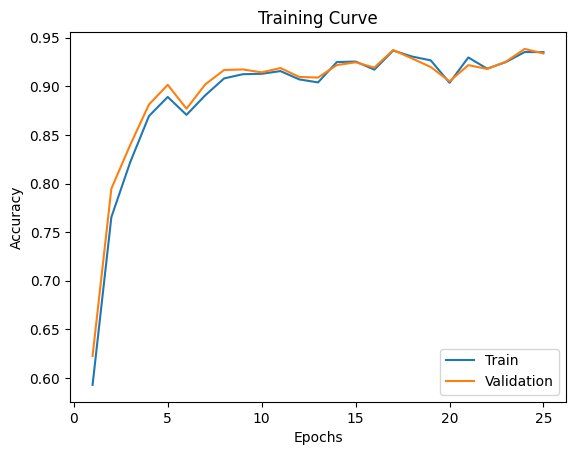

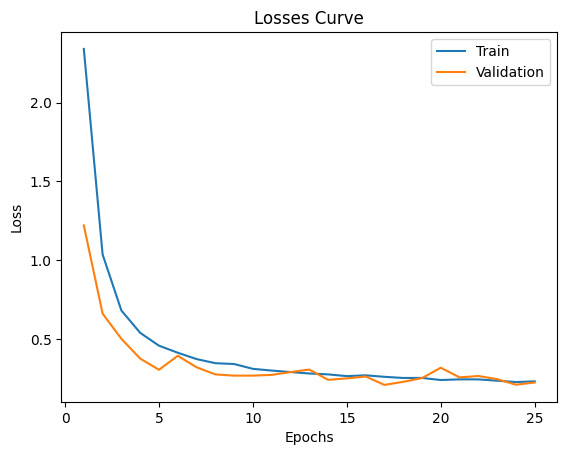

In [ ]:
plotting(epochs, training_acc, training_loss, validation_acc,  val_loss)